#**Практическое задание №1**

Установка необходимых пакетов:

In [35]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [36]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [37]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [38]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

%matplotlib inline

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [39]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 128MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 1.
Label code corresponds to BACK class.


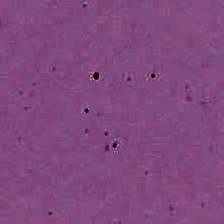

In [40]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [41]:
# ============================================================
# (Опционально) Обёртка над Dataset для использования с PyTorch
# ============================================================

# ВНИМАНИЕ:
# Этот код нужен только тем, кто хочет решать задание с помощью PyTorch.
# Он показывает, как "подключить" наш Dataset к torch.utils.data.DataLoader.

try:
    import torch
    from torch.utils.data import Dataset as TorchDataset, DataLoader
    import torchvision.transforms as T
    from PIL import Image

    class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor
            return img, label

except ImportError:
    HistologyTorchDataset = None
    print("PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.")

### Пример использвания класса HistologyTorchDataset

In [42]:
if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))


Пример использования PyTorch-обёртки над Dataset


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:03<00:00, 31.5MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
Форма батча изображений: (8, 3, 224, 224)
Форма батча меток: (8,)
Пример меток: [6, 8, 0, 3, 6, 3, 1, 0]
Тип images_batch: <class 'torch.Tensor'>
Тип labels_batch: <class 'torch.Tensor'>


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [43]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import os

from tqdm.auto import tqdm

In [45]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import models

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

class Model:

    def __init__(self):

        #LBL1
        self.compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device:", self.compute_device)

        #LBL2
        self.num_classes = len(TISSUE_CLASSES)
        self.img_size = 224
        self.mean = (0.485, 0.456, 0.406)
        self.std  = (0.229, 0.224, 0.225)

        #LBL3
        self.model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )

        #LBL4
        for p in self.model.features.parameters():
            p.requires_grad = False

        #LBL5
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, self.num_classes)

        self.model.to(self.compute_device)

        self.train_transforms = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.ToTensor(),
            T.Normalize(self.mean, self.std),
        ])
        self.eval_transforms = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.ToTensor(),
            T.Normalize(self.mean, self.std),
        ])

        self.ckpt_root = "/content/drive/MyDrive/checkpoints"
        os.makedirs(self.ckpt_root, exist_ok=True)


    def _set_seed(self, seed: int = 42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def _numpy_to_tensor(self, img: np.ndarray) -> torch.Tensor:
        from PIL import Image
        pil = Image.fromarray(img)
        x = self.eval_transforms(pil).unsqueeze(0).to(self.compute_device)
        return x

    def _evaluate(self, loader):
        self.model.eval()
        criterion = nn.CrossEntropyLoss()
        total_loss = 0.0

        all_true = []
        all_pred = []

        with torch.no_grad():
            for images, labels in loader:
                images = images.to(self.compute_device)
                labels = labels.to(self.compute_device)

                logits = self.model(images)
                loss = criterion(logits, labels)
                total_loss += float(loss.detach().cpu()) * images.size(0)

                preds = logits.argmax(1)
                all_true.extend(labels.detach().cpu().numpy().tolist())
                all_pred.extend(preds.detach().cpu().numpy().tolist())

        avg_loss = total_loss / max(1, len(all_true))
        acc = 100.0 * accuracy_score(all_true, all_pred)
        bal_acc = 100.0 * balanced_accuracy_score(all_true, all_pred)
        return avg_loss, acc, bal_acc

    def _split_train_val(self, labels: np.ndarray, val_size: float = 0.2, seed: int = 42):
        labels = np.asarray(labels)
        rng = np.random.default_rng(seed)
        idx = np.arange(len(labels))

        tr_idx, va_idx = [], []
        for c in np.unique(labels):
            c_idx = idx[labels == c]
            rng.shuffle(c_idx)
            k = max(1, int(len(c_idx) * val_size))
            va_idx.append(c_idx[:k])
            tr_idx.append(c_idx[k:])

        tr_idx = np.concatenate(tr_idx)
        va_idx = np.concatenate(va_idx)
        rng.shuffle(tr_idx)
        rng.shuffle(va_idx)
        return tr_idx, va_idx

    def _save_checkpoint(self, path: str, epoch: int, best_metric: float, history: dict):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(
            {
                "state_dict": self.model.state_dict(),
                "epoch": epoch,
                "best_metric": best_metric,
                "history": history,
                "img_size": self.img_size,
                "mean": self.mean,
                "std": self.std,
                "num_classes": self.num_classes,
            },
            path
        )

    def load_checkpoint(self, path: str, strict: bool = True):
        chkpt = torch.load(path, map_location=self.compute_device)
        state = chkpt.get("state_dict", chkpt)
        self.model.load_state_dict(state, strict=strict)

        self.img_size = int(chkpt.get("img_size", self.img_size))
        self.mean = tuple(chkpt.get("mean", self.mean))
        self.std  = tuple(chkpt.get("std", self.std))

        self.train_transforms = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.ToTensor(),
            T.Normalize(self.mean, self.std),
        ])
        self.eval_transforms = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.ToTensor(),
            T.Normalize(self.mean, self.std),
        ])

        self.model.to(self.compute_device)
        return chkpt

    def load_epoch(self, epoch: int):
        #LBL4
        path = os.path.join(self.ckpt_root, f"epoch_{epoch:02d}.pth")
        return self.load_checkpoint(path, strict=True)


    def train(self, dataset, max_epochs: int = 15, val_size: float = 0.2, seed: int = 42):

        print("training started")
        self._set_seed(seed)
        #LBL1

        labels = getattr(dataset, "labels", None)
        if labels is None:
            raise ValueError("Dataset must expose `.labels` for stratified validation split.")

        tr_idx, va_idx = self._split_train_val(labels, val_size=val_size, seed=seed)

        full_train_ds = HistologyTorchDataset(dataset, transform=self.train_transforms)
        full_val_ds   = HistologyTorchDataset(dataset, transform=self.eval_transforms)

        train_ds = torch.utils.data.Subset(full_train_ds, tr_idx)
        val_ds   = torch.utils.data.Subset(full_val_ds, va_idx)

        train_loader = DataLoader(
            train_ds, batch_size=32, shuffle=True,
            num_workers=0, pin_memory=(self.compute_device.type == "cuda")
        )
        val_loader = DataLoader(
            val_ds, batch_size=64, shuffle=False,
            num_workers=0, pin_memory=(self.compute_device.type == "cuda")
        )

        optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_losses = [], []
        train_accs, val_accs, val_bal_accs = [], [], []

        best_metric = -1.0

        history = {
            "train_loss": train_losses,
            "val_loss": val_losses,
            "train_acc": train_accs,
            "val_acc": val_accs,
            "val_bal_acc": val_bal_accs,
        }

        for epoch in range(max_epochs):

            self.model.train()
            total_loss = 0.0
            all_true, all_pred = [], []

            for images, labels_b in train_loader:
                images = images.to(self.compute_device)
                labels_b = labels_b.to(self.compute_device)

                optimizer.zero_grad(set_to_none=True)
                logits = self.model(images)
                loss = criterion(logits, labels_b)
                loss.backward()
                optimizer.step()

                total_loss += float(loss.detach().cpu()) * images.size(0)
                preds = logits.argmax(1)
                all_true.extend(labels_b.detach().cpu().numpy().tolist())
                all_pred.extend(preds.detach().cpu().numpy().tolist())

            train_loss = total_loss / max(1, len(all_true))
            train_acc = 100.0 * accuracy_score(all_true, all_pred)

            val_loss, val_acc, val_bal_acc = self._evaluate(val_loader)

            #LBL5
            print(
                f"Epoch {epoch+1:02d}/{max_epochs} | "
                f"train_loss={train_loss:.4f} train_acc={train_acc:.2f}% | "
                f"val_loss={val_loss:.4f} val_acc={val_acc:.2f}% val_bal_acc={val_bal_acc:.2f}%"
            )

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_bal_accs.append(val_bal_acc)

            #LBL3
            epoch_path = os.path.join(self.ckpt_root, f"epoch_{epoch:02d}.pth")
            self._save_checkpoint(epoch_path, epoch=epoch, best_metric=best_metric, history=history)

            metric_value = val_bal_acc
            if metric_value > best_metric:
                best_metric = metric_value
                best_path = os.path.join(self.ckpt_root, "best.pth")
                self._save_checkpoint(best_path, epoch=epoch, best_metric=best_metric, history=history)

        print("training done")
        return train_losses, val_losses, train_accs, val_accs

    def cross_validate(self, dataset, k_folds: int = 5, epochs_per_fold: int = 5, seed: int = 42):
        #LBL2

        labels = getattr(dataset, "labels", None)
        if labels is None:
            raise ValueError("Dataset must expose `.labels` for cross-validation.")

        self._set_seed(seed)
        labels = np.asarray(labels)

        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
        fold_scores = []

        for fold, (tr_idx, va_idx) in enumerate(skf.split(np.arange(len(labels)), labels), start=1):

            tmp = Model()  # fresh model
            tmp.ckpt_dir = os.path.join(self.ckpt_root, f"cv_fold_{fold}")
            os.makedirs(tmp.ckpt_dir, exist_ok=True)

            full_train_ds = HistologyTorchDataset(dataset, transform=tmp.train_tfms)
            full_val_ds   = HistologyTorchDataset(dataset, transform=tmp.eval_tfms)

            train_ds = torch.utils.data.Subset(full_train_ds, tr_idx)
            val_ds   = torch.utils.data.Subset(full_val_ds, va_idx)

            train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
            val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

            optimizer = optim.Adam(tmp.model.parameters(), lr=1e-3)
            criterion = nn.CrossEntropyLoss()

            for epoch in range(epochs_per_fold):
                tmp.model.train()
                for images, labels_b in train_loader:
                    images = images.to(tmp.device)
                    labels_b = labels_b.to(tmp.device)

                    optimizer.zero_grad(set_to_none=True)
                    logits = tmp.model(images)
                    loss = criterion(logits, labels_b)
                    loss.backward()
                    optimizer.step()

                vloss, vacc, vbal = tmp._evaluate(val_loader)
                print(f"[CV] fold {fold}/{k_folds} epoch {epoch+1}/{epochs_per_fold}: val_acc={vacc:.2f}% val_bal_acc={vbal:.2f}%")

            vloss, vacc, vbal = tmp._evaluate(val_loader)
            fold_scores.append(vbal)
            print(f"[CV] fold {fold}/{k_folds} итог: val_bal_acc={vbal:.2f}%")

        mean = float(np.mean(fold_scores)) if fold_scores else 0.0
        std  = float(np.std(fold_scores)) if fold_scores else 0.0
        print(f"[CV] mean val_bal_acc = {mean:.2f}% ± {std:.2f}%")
        return mean, std


    def save(self, name: str):
        best_path = os.path.join(self.ckpt_root, "best.pth")
        if not os.path.exists(best_path):
            best_path = os.path.join(self.ckpt_root, "best.pth")
            self._save_checkpoint(best_path, epoch=-1, best_metric=float("nan"), history={})

        target = f"/content/drive/MyDrive/{name}.pth"
        os.makedirs(os.path.dirname(target), exist_ok=True)
        import shutil
        shutil.copy(best_path, target)
        print(f"Saved best checkpoint to {target}")


    def load(self, name="best", epoch=None, path=None):
      if path is None:
          if epoch is not None:
              fname = f"epoch_{int(epoch):02d}.pth"
          else:
              fname = f"{name}.pth"
          path = os.path.join(self.ckpt_root, fname)

      if not os.path.exists(path):
          raise FileNotFoundError(f"Checkpoint not found: {path}")

      try:
          ckpt = torch.load(path, map_location=self.compute_device, weights_only=False)
      except TypeError:
          ckpt = torch.load(path, map_location=self.compute_device)

      if isinstance(ckpt, dict) and "state_dict" in ckpt:
          state = ckpt["state_dict"]

          if "img_size" in ckpt:
              self.img_size = int(ckpt["img_size"])
          if "mean" in ckpt:
              self.mean = tuple(float(x) for x in ckpt["mean"])
          if "std" in ckpt:
              self.std = tuple(float(x) for x in ckpt["std"])
      else:
          state = ckpt

      self.model.load_state_dict(state, strict=True)
      self.model.to(self.compute_device)
      self.model.eval()

      self.train_transforms = T.Compose([
          T.Resize((self.img_size, self.img_size)),
          T.ToTensor(),
          T.Normalize(self.mean, self.std),
      ])
      self.eval_transforms = T.Compose([
          T.Resize((self.img_size, self.img_size)),
          T.ToTensor(),
          T.Normalize(self.mean, self.std),
      ])

      print(f"Loaded checkpoint: {path}")



    def test_on_dataset(self, dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        self.model.eval()
        with torch.no_grad():
            x = self._numpy_to_tensor(img)
            logits = self.model(x)
            pred = int(logits.argmax(1).item())
        return pred


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [46]:
d_train = Dataset('train')
d_test = Dataset('test')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:35<00:00, 59.6MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr
To: /content/test.npz
100%|██████████| 525M/525M [00:11<00:00, 46.2MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [47]:
model = Model()
if not EVALUATE_ONLY:
    train_losses, val_losses, train_accs, val_accs = model.train(d_train, max_epochs=10, val_size=0.2, seed=42)
    model.save('best')

else:
    model.load('best')


Device: cuda
training started
Epoch 01/10 | train_loss=0.4912 train_acc=87.50% | val_loss=0.2081 val_acc=94.92% val_bal_acc=94.92%
Epoch 02/10 | train_loss=0.2460 train_acc=92.64% | val_loss=0.1657 val_acc=95.44% val_bal_acc=95.44%
Epoch 03/10 | train_loss=0.2133 train_acc=93.36% | val_loss=0.1464 val_acc=95.75% val_bal_acc=95.75%
Epoch 04/10 | train_loss=0.1900 train_acc=93.88% | val_loss=0.1370 val_acc=96.17% val_bal_acc=96.17%
Epoch 05/10 | train_loss=0.1804 train_acc=94.32% | val_loss=0.1317 val_acc=96.00% val_bal_acc=96.00%
Epoch 06/10 | train_loss=0.1768 train_acc=94.16% | val_loss=0.1322 val_acc=96.00% val_bal_acc=96.00%
Epoch 07/10 | train_loss=0.1723 train_acc=94.23% | val_loss=0.1258 val_acc=96.14% val_bal_acc=96.14%
Epoch 08/10 | train_loss=0.1654 train_acc=94.44% | val_loss=0.1225 val_acc=96.31% val_bal_acc=96.31%
Epoch 09/10 | train_loss=0.1626 train_acc=94.46% | val_loss=0.1209 val_acc=96.50% val_bal_acc=96.50%
Epoch 10/10 | train_loss=0.1531 train_acc=94.99% | val_loss=0

In [48]:
EVALUATE_ONLY = True

model = Model()
model.load('best')

Device: cuda
Loaded checkpoint: /content/drive/MyDrive/checkpoints/best.pth


Пример тестирования модели на части набора данных:

In [49]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

  0%|          | 0/450 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 0.9800:
	 balanced accuracy 0.9800:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [50]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9618:
	 balanced accuracy 0.9618:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [51]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Device: cuda
Loaded checkpoint: /content/drive/MyDrive/checkpoints/best.pth


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 52.4MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9444:
	 balanced accuracy 0.9444:


Отмонтировать Google Drive.

In [52]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [53]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

Function f is caluclated 128 times in 0.02529140000001462s.


### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### PyTorch

In [54]:
# ============================================================
# Дополнительно: мини-демо PyTorch
# ============================================================
# Ранний выход, если PyTorch/обёртка недоступны
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
except ImportError:
    print("PyTorch не установлен — демо пропущено.")
    import sys
    raise SystemExit

if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("HistologyTorchDataset недоступна — демо пропущено.")
    import sys
    raise SystemExit


# --- Данные: tiny-наборы, чтобы выполнялось быстро ---
base_train = Dataset('train_tiny')
base_test  = Dataset('test_tiny')

train_ds = HistologyTorchDataset(base_train)           # ToTensor по умолчанию
test_ds  = HistologyTorchDataset(base_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# --- Мини-модель: двухслойный CNN + один FC (демонстрация, не решение) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=len(TISSUE_CLASSES)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # 224->112->56
        self.fc    = nn.Linear(16 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 3, 224, 224] -> [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 112, 112] -> [B, 16, 56, 56]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TinyCNN(num_classes=len(TISSUE_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Один учебный шаг "обучения" на одном батче ---
model.train()
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device, dtype=torch.long)

optimizer.zero_grad()
logits = model(xb)
loss = criterion(logits, yb)
float_loss = float(loss.detach().cpu())
loss.backward()
optimizer.step()

print(f"Loss на одном батче train_tiny: {float_loss:.4f}")

# --- Быстрая проверка на одном батче теста (для формы вывода/метрик) ---
model.eval()
with torch.no_grad():
    xt, yt = next(iter(test_loader))
    xt = xt.to(device)
    logits_t = model(xt).cpu()
    y_pred = logits_t.argmax(dim=1).numpy()
    y_true = yt.numpy()

print("Размерности:", {"y_true": y_true.shape, "y_pred": y_pred.shape})
Metrics.print_all(y_true, y_pred, "_")  # balanced accuracy/accuracy на одном батче для демонстрации

# для полноценного решения требуется собственный тренировочный цикл по эпохам,
# аугментации/нормализация, сохранение/загрузка весов, и тестирование на всём наборе.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 117MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 52.2MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
Device: cuda
Loss на одном батче train_tiny: 2.2218
Размерности: {'y_true': (32,), 'y_pred': (32,)}
metrics for _:
	 accuracy 0.0000:
	 balanced accuracy 0.0000:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [55]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dev/prak_nn_1/tmp'

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"